### Character Level Language Model using LSTM

Use the following import if using google colab environemt

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Import the necessary librariries and frameworks

Keras is high level API that supports popular frameworks like CNTK and TensorFlow. Its declarative API makes it easy to build deep learning mdoels. <br>
Though keras support multiple backends, code is teseted with Tensorflow 1.13 backend.

In [2]:
import json
import os
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

Using TensorFlow backend.


#### Root Path
The notebook assumes a root path, which is the **absolute** path of location in which notebook is. <br> Adjust the path accordinly, it must also have following ***data*** and ***model_checkpoint*** folders.<br>
The expected directory structure is <br>
|--root_path <br>
|--|--data<br>
|--|--|--all_story_cleaned.txt<br>
|--|--|--vocab_clenaed-50.json<br>
|--|--model_checkpoint<br> 

In [0]:
root_path = "gdrive/My Drive/colab_notebooks/charles-dickens-charlevel-50"

#### Read the file and *vocabulary*

In [0]:
with open(root_path + "/data/all_story_cleaned.txt", encoding = "utf-8") as f:
  raw_text = f.read()
  
with open(root_path + "/data/vocab_clenaed-50.json", encoding="utf-8") as f:
  json_dump = json.load(f)
  char_to_int = json_dump["char_to_int"]
  int_to_char = json_dump["int_to_char"]
  int_to_char = {int(k):int_to_char[k] for k in int_to_char}

#### Common variables

In [0]:
n_vocab = len(int_to_char)
max_len = 50
batch_size = 1024

DataGenerator similar to PyTorch DataLoader class. All possible pairs X and y, casue combatorial explostion, thus pairs cannot be generated and stored in memory prior. 
We define a **DataGenerator** class which extends *keras.utils.Sequence*. 
The most important method to be implemented is

\__getitem__: this method expects the index which is batch index, and return pair of X and y values for model to fit. 




In [0]:
class DataGenerator(keras.utils.Sequence):
  
  def __init__(self, raw_text, char_to_int, int_to_char, max_len, batch_size):
    
    # convert the raw text to tokenized text by applying char_to_int dictionary
    self.tokenized_text = np.zeros(len(raw_text))
    for i, c in enumerate(raw_text):
      self.tokenized_text[i] = char_to_int[c]
    
    # store variables to be used later
    self.char_to_int = char_to_int
    self.int_to_char = int_to_char
    self.max_len = max_len
    self.batch_size = batch_size
    self.vocab_size = len(char_to_int)
    self.len = int((len(self.tokenized_text) / max_len) / batch_size)
    

  def __len__(self):
    return self.len

  # method called for each batch, must return pair of X and y 
  def __getitem__(self, index):

    # prepare a zero intialized array 
    # shape of X = (batch_size, max_len, vocab_size)
    X = np.zeros((self.batch_size, self.max_len, self.vocab_size))
    # shape of y = (batch_size, vocab_size)
    y = np.zeros((self.batch_size, self.vocab_size))

    # until sufficient number of pairs are generated
    for i in range(self.batch_size):

      # randomly select a starting point for the sequence
      start = np.random.randint(len(self.tokenized_text)-(self.max_len + 1))
      
      # select max_len characters from starting portion using [start : start + self.max_len]
      # also one hot encode the selected portion
      x_seq = np_utils.to_categorical(self.tokenized_text[start : start + self.max_len], num_classes=self.vocab_size)
      # select the next character as target using [start + self.max_len]
      # one hot encode this too
      y_target = np_utils.to_categorical(self.tokenized_text[start + self.max_len], num_classes=self.vocab_size)
      
      # set to np array appropriately
      X[i, :, :] = x_seq

      y[i] = y_target
      
    # return the pair
    return X, y

#### Intialize the Train and Validation Generator

In [0]:
train_gen = DataGenerator(raw_text, char_to_int, int_to_char, max_len, batch_size)
val_gen = DataGenerator(raw_text, char_to_int, int_to_char, max_len, batch_size)

### Model Definition

In [0]:
model = Sequential()

# add LSTM layer of 512 hidden units and input shape (?, max_len, n_vocab)
# batch size is not needed
# return_sequence must be set to True, to return activation value from all time slices and not just the last one.
model.add(LSTM(512, input_shape=(max_len, n_vocab), return_sequences=True, name="lstm-1"))

# add a dropout layer, with dropout rate of 0.4
model.add(Dropout(rate = 0.4, name="dropout-1"))

# another LSTM layer, no need for input shape, can be infered from previous layer
model.add(LSTM(256, name="lstm-2", return_sequences=True))

# add another dorpout layer
model.add(Dropout(rate = 0.4, name="dropout-2"))

# final LSTM layer with 256 hidden units
# return_sequences = False, because in last layer we are only interested for latest activation value
model.add(LSTM(256, name="lstm-3"))

# last dropout layer
model.add(Dropout(rate = 0.4, name="dropout-3"))

# a fully connected layer, with softmax activation
# the output size is n_vocab (50)
model.add(Dense(n_vocab, activation='softmax', name="dense-1"))


# define the optimizer, and set learning rate. Other options like gradient clipping can also be set here.
adam_opt = keras.optimizers.Adam(lr=0.0001)

# finally compile model.
# loss function is categorical_crossentropy, metrics to be printed alongside loss is accuracy (only for visual aid)
# set the optimzer previously defined
model.compile(optimizer=adam_opt,
            loss='categorical_crossentropy', metrics=["accuracy"])

# print the summary
model.summary()

# to be uncommeted if loading weights from previouly saved model
# model.load_weights(root_path+"/model_checkpoint/"+"best_model-3layer.h5", by_name=True)

# prepare a callback to save model at the end of epochs.
model_checkpoint = ModelCheckpoint(root_path+"/model_checkpoint/"+"best_model-3layer.h5", 
                                   save_best_only=True, verbose=1, monitor="val_loss")
callbacks_list = [model_checkpoint]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm-1 (LSTM)                (None, 50, 512)           1153024   
_________________________________________________________________
dropout-1 (Dropout)          (None, 50, 512)           0         
_________________________________________________________________
lstm-2 (LSTM)                (None, 50, 256)           787456    
_________________________________________________________________
dropout-2 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm-3 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout-3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense-1 (Dense)              (None, 50)                12850     
Total para

In [0]:
# save the visual drawing of the model (optional)
from keras.utils import plot_model
plot_model(model, to_file=root_path + '/model-simple-lstm.png', show_shapes=True, show_layer_names = True)

#### Training

In [0]:
# call the fit method similar to sklearn
# pass in the train and validation generator, number of epochs
# steps per epoch defines the number of batches to be trained on per epoch
history = model.fit_generator(generator = train_gen, steps_per_epoch=100, 
                              validation_data=val_gen, validation_steps=30, 
                              epochs=100, callbacks = callbacks_list)

#### Plot the History

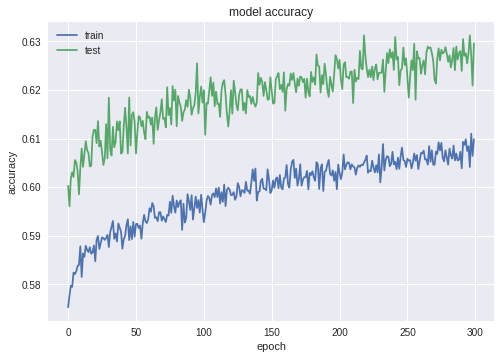

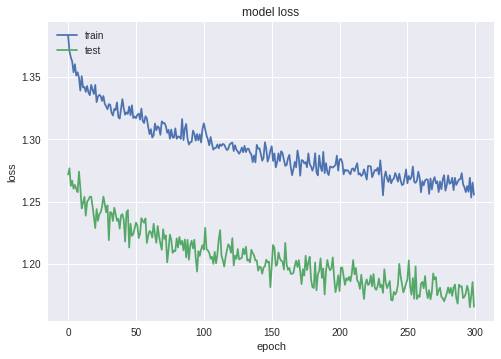

In [0]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Sample Generation

**Important Note** a separate file is prepared to generate sample more cleanly, under LM-SampleGenration folder. Please use that notebook.<br>
Nevertheless these methods can also be used.

Method to sample a chracter given propbabilities generated from model predict method.

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Parent method that calls ****sample**** method. Text samples are generated for different temperature values. <br>
The seed text is selected randomly. Total of 200 characters are additionally generated and appended to the seed text to produce generated text.

In [0]:
def generate_sample(model):
  for diversity in [0.7, 0.7, 0.6, 0.6,0.5, 0.5, 0.4, 0.4]:
    print('----- diversity:', diversity)
    start = np.random.randint(len(raw_text)-(max_len + 1)) 
    text = raw_text [start : start + max_len]
    tokenized_text = [char_to_int[c] for c in text]
    x_seq = np_utils.to_categorical(tokenized_text, num_classes=n_vocab)
    x_seq = np.expand_dims(x_seq, axis = 0)
    
    print("seed:", text)
    
    for i in tqdm(range(200)):
      preds = model.predict(x_seq, verbose=0)[0]
      next_index = sample(preds, diversity)
      next_char = int_to_char[next_index]
      text = text + next_char
      new_arr = np_utils.to_categorical(next_index, num_classes=n_vocab).reshape(1, 1, -1)
      x_seq = np.concatenate([x_seq, new_arr], axis = 1)[:, 1:, :]
    print("\nGenerated text:\n", text)
    
    print("\n\n")

generate_sample(model)

Similar to generate sample above. It uses a ***custom seed*** instead of selecting one from raw text file.

In [0]:

def generate_sample(model):
  for diversity in [0.7, 0.7, 0.5, 0.5, 0.6, 0.6]:
    print('----- diversity:', diversity)
    start = np.random.randint(len(raw_text)-(max_len + 1))
    
    # change to custom text you want
    text = " "*max_len +"You shall know a word by ".lower()
    text = text[-max_len:]
    print(text)

    tokenized_text = [char_to_int[c] for c in text]
    x_seq = np_utils.to_categorical(tokenized_text, num_classes=n_vocab)
    x_seq = np.expand_dims(x_seq, axis = 0)
    
    print("seed:", text)
    
    for i in tqdm(range(200)):
      preds = model.predict(x_seq, verbose=0)[0]
      next_index = sample(preds, diversity)
      next_char = int_to_char[next_index]
      text = text + next_char
      new_arr = np_utils.to_categorical(next_index, num_classes=n_vocab).reshape(1, 1, -1)
      x_seq = np.concatenate([x_seq, new_arr], axis = 1)[:, 1:, :]
    print("\nGenerated text:\n", text)
    
    print("\n\n")

generate_sample(model)
